# Practice for the estimation of Q and R in data assimilation (correction)

This Jupyter notebook is part of the intensive course on data assimilation and filtering techniques that held in Buenos Aires in October 2019. It uses the **pykalman** and **CEDA** Python libraries respectively available at https://github.com/pykalman and https://github.com/ptandeo/CEDA. CEDA stands for "Covariance Estimation in Data Assimilation". Do not hesitate to contact me (pierre.tandeo@imt-atlantique.fr) for more details.

### PROBLEM STATEMENT

Data assimilation are numerical methods used in geophysics to mix the information of observations (noted as $y$) and a dynamical model (noted as $\mathcal{M}$). The goal is to estimate the true/hidden state of the system (noted as $x$) at every time step $k$. Usually, data assimilation problems are stated as nonlinear state-space models:

\begin{align*}
x(k) & = \mathcal{M}\left(x(k-1)\right) + \eta(k) \\
y(k) & = \mathcal{H}\left(x(k)\right) + \epsilon(k)
\end{align*}

with $\eta$ and $\epsilon$ some independent white Gaussian noises respectively representing the model and the observation errors. These errors are supposed to be unbiased with covariances noted $Q$ and $R$. Here, we propose to use the Expectation-Maximization (EM) algorithm to estimate $Q$ and $R$.

### The batch EM algorithm for state-space models

EM algorithm is a common algorithm in the statistical society. The goal of EM is to maximize a likelihood function. In our case (state-space models), the likelihood function to maximize is 
\begin{align*}
%& p\left(y(1:K), x(0:K)|Q, R \right) = & \nonumber \\ 
& \mathcal{L}(Q,R) = p\left(x(0)\right) \prod_{k=1}^K p\left(x(k)|x(k-1),Q\right) \prod_{k=1}^K p\left(y(k)|x(k),R\right) & 
\end{align*}
where the first term corresponds to the initial condition, the second term to the dynamic equation, the third term to the observation equation. Note that $K$ is the total number of observations.

The $\mathcal{L}(Q,R)$ likelihood is said to be "total" because we consider the all state-space model at all time steps. In practice, we can not maximize directly this likelihood w.r.t. $Q$ and $R$ because the sequence $x(0),\dots,x(K)$ is unknown and depends itself on $Q$ and $R$. We thus need an iterative procedure to first estimate the sequence $x(0),\dots,x(K)$ and then to update $Q$ and $R$. This is the purpose of the EM algorithm.

The 2 main steps in EM are (1) the Expectation and (2) the Maximization. EM algorithm is iterative and we note $j$ the current iteration. Starting from an initial condition $Q^{(0)}$ and $R^{(0)}$, EM repeats these 2 steps until converge:

1) E-step: compute the "expectation" of the likelihood function conditionally on the previous estimates $Q^{(j-1)}$ and $R^{(j-1)}$. Mathematically, it is written as $E\left[\mathcal{L}(Q,R)|y(0),\dots,y(K),Q^{(j-1)},R^{(j-1)}\right]$. This expectation is also conditionally on the whole sequence of observations $y(0),\dots,y(K)$. We thus need to use the Kalman smoother to approximate as best this expectation.

2) M-step: "maximize" $E\left[\mathcal{L}(Q,R)|y(0),\dots,y(K),Q^{(j-1)},R^{(j-1)}\right]$ w.r.t. $Q$ and $R$. This maximization can be done using optimization techniques (e.g., gradient descent) or using an analytic formula. The resulting covariance estimates are $Q^{(j)}$ and $R^{(j)}$. 

### EM algorithm using the linear and Gaussian state-space model

Here, we consider the case where $\mathcal{M}$ and $\mathcal{H}$ are linear operators (i.e. $M$ and $H$ matrices). The EM for the corresponding linear and Gaussian state-space model is known for a long time and given in Shumway and Stoffer (1982), see https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1467-9892.1982.tb00349.x. This algorithm is coded in the **pykalman** Python library. Here, we aim to apply the EM algorithm on a simple problem.

**Question)** Generate data from the following linear and Gaussian state-space model:
\begin{align}
  x(k) & = 0.95 x(k-1) + \eta(k)\\
  y(k) & = x(k) + \epsilon(k)
\end{align}
with $\eta(k) \sim \mathcal{N}\left(0,Q^{true}=1\right)$ and $\epsilon(k) \sim \mathcal{N}\left(0,R^{true}=1\right)$. Use the function *random.normal* to generate the Gaussian noises. Then, plot the $x$ and $y$ time series.

Populating the interactive namespace from numpy and matplotlib
(1, 1)


Text(0.5, 1.0, 'Simulated data from a linear Gaussian state-space model')

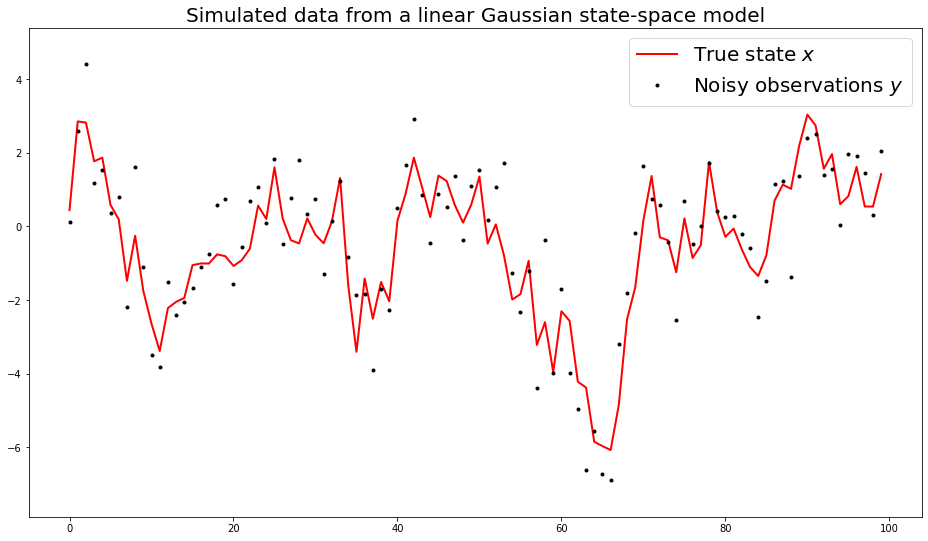

In [3]:
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)
numpy.random.seed(5)

# generate true state and noisy observations
Q_true=eye(1)
R_true=eye(1)
print(R_true.shape)
K=100
x_true=zeros(K)
y=zeros(K)
for k in range(K):
    x_true[k]=0.95*x_true[k-1]+random.normal(0,Q_true) ### HIDE HERE ###
    y[k]=x_true[k]+random.normal(0,R_true) ### HIDE HERE ###


# plot results
figure()
line1,=plot(range(K),x_true,'r',linewidth=2)
line2,=plot(range(K),y,'.k')
legend([line1, line2], ['True state $x$', 'Noisy observations $y$'], prop={'size': 20})
ylim(min(y)-1,max(y)+1)
title('Simulated data from a linear Gaussian state-space model', fontsize=20)

Now, we apply the Kalman smoother using the true parameters: $M=0.95$, $H=1$, $Q=Q^{true}$ and $R=R^{true}$. We plot the corresponding results. The estimated state using Kalman is close to the truth and the $95\%$ confidence interval seems realistic.

(100,)


Text(0.5, 1.0, 'Results of the Kalman smoother')

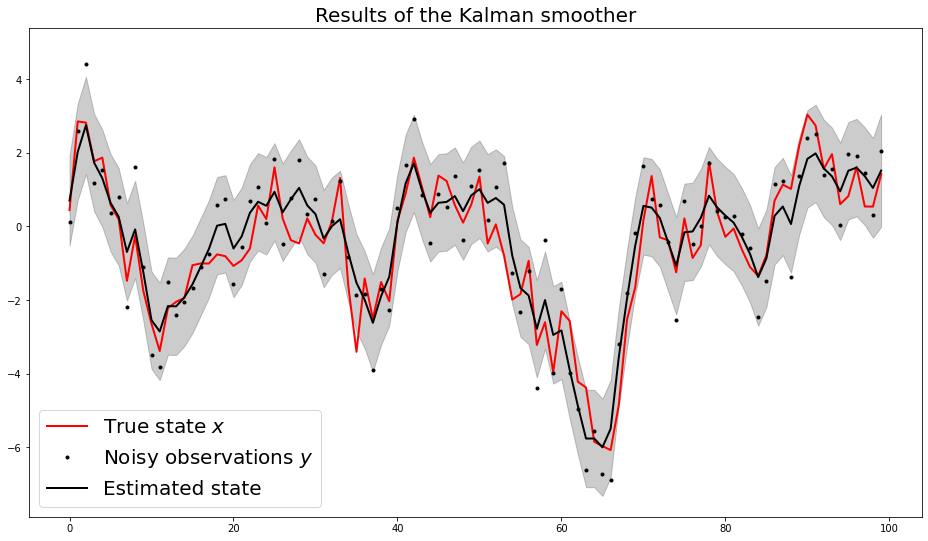

In [4]:
# library for Kalman filter/smoother and EM algorithm (linear case)
from pykalman import KalmanFilter

# apply Kalman smoother with good covariances
KF_true_Q_R=KalmanFilter(transition_matrices = [[0.95]], observation_matrices = [[1]],
                         initial_state_mean = [[0]], initial_state_covariance = [[1]],
                         transition_covariance = Q_true, observation_covariance = R_true)

xs_true_Q_R, Ps_true_Q_R=KF_true_Q_R.smooth(y)

# plot results
figure()
line1,=plot(range(K),x_true,'r',linewidth=2)
line2,=plot(range(K),y,'.k')
line3,=plot(range(K),xs_true_Q_R,'k',linewidth=2)
fill_between(range(K), squeeze(xs_true_Q_R) - 1.96 * sqrt(squeeze(Ps_true_Q_R)),
             squeeze(xs_true_Q_R) + 1.96 * sqrt(squeeze(Ps_true_Q_R)), color='k', alpha=.2)
legend([line1, line2, line3], ['True state $x$', 'Noisy observations $y$', 'Estimated state'], prop={'size': 20})
ylim(min(y)-1,max(y)+1)
title('Results of the Kalman smoother', fontsize=20)

**Question)** Now, apply the Kalman smoother changing the values of $Q$ and $R$. Firstly, you can fix $R=R^{true}=1$ and vary $Q$. Secondly, you can fix $Q=Q^{true}=1$ and vary $R$. Thirdly, you can change both $Q$ and $R$. What are your feelings about the results, both in term of estimated mean ($x^s$) and variance ($P^s$)?

Text(0.5,1,'Results with different Kalman smoother configurations')

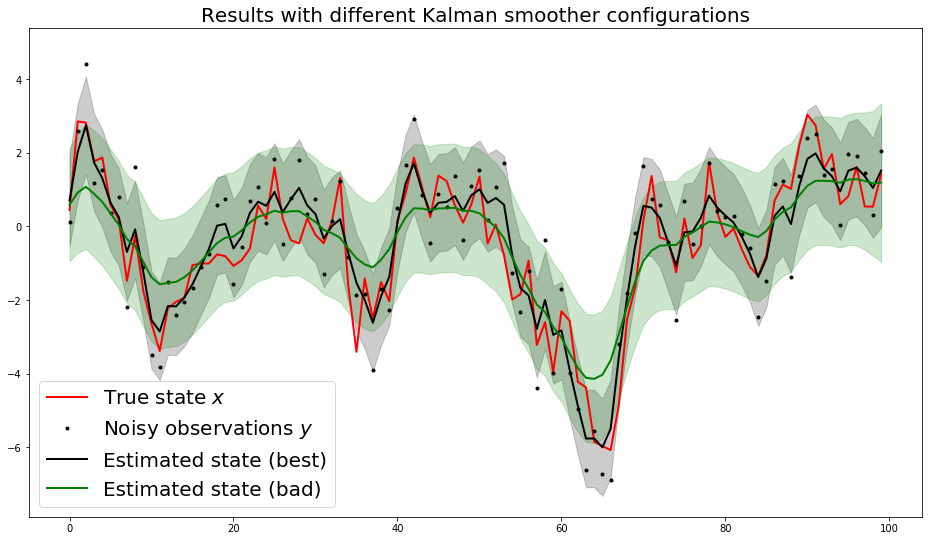

In [3]:
###########################
### HIDE THE WHOLE CELL ###
###########################

# apply Kalman smoother with bad covariances
KF_bad_Q_R=KalmanFilter(transition_matrices = [[0.95]], observation_matrices = [[1]],
                        initial_state_mean = [[0]], initial_state_covariance = [[1]],
                        transition_covariance = 0.5*Q_true, observation_covariance = 5*R_true)
xs_bad_Q_R, Ps_bad_Q_R=KF_bad_Q_R.smooth(y)

# plot results
figure()
line1,=plot(range(K),x_true,'r',linewidth=2)
line2,=plot(range(K),y,'.k')
line3,=plot(range(K),xs_true_Q_R,'k',linewidth=2)
fill_between(range(K), squeeze(xs_true_Q_R) - 1.96 * sqrt(squeeze(Ps_true_Q_R)),
             squeeze(xs_true_Q_R) + 1.96 * sqrt(squeeze(Ps_true_Q_R)), color='k', alpha=.2)
line4,=plot(range(K),xs_bad_Q_R,'g',linewidth=2)
fill_between(range(K), squeeze(xs_bad_Q_R) - 1.96 * sqrt(squeeze(Ps_bad_Q_R)),
             squeeze(xs_bad_Q_R) + 1.96 * sqrt(squeeze(Ps_bad_Q_R)), color='g', alpha=.2)
legend([line1, line2, line3, line4], ['True state $x$', 'Noisy observations $y$', 'Estimated state (best)', 'Estimated state (bad)'], prop={'size': 20})
ylim(min(y)-1,max(y)+1)
title('Results with different Kalman smoother configurations', fontsize=20)

The results above clearly show that the quality of the estimation highly depends on $Q$ and $R$. But in practice, we don't know the optimal values. A solution is to use the batch EM algorithm to estimate automatically these quantities. This is implemented in the *em* function of the **pykalman** library. First, we initialize the state-space model with arbitrary $Q^{(0)}$ and $R^{(0)}$ values. Then, we run the EM algorithm with a given number of iterations. Finally, we print the estimated values of $Q$ and $R$.

In [4]:
# define the state-space model
KF_estimate_Q_R=KalmanFilter(transition_matrices = [[0.95]], observation_matrices = [[1]],\
                             initial_state_mean = [[0]], initial_state_covariance = [[1]],\
                             transition_covariance = 0.5*Q_true,\
                             observation_covariance = 5*R_true)

# apply EM algorithm (for only Q and R)
KF_estimate_Q_R.em(y, n_iter=100, em_vars=['transition_covariance','observation_covariance'])

# plot Q and R estimates
print('Q estimates: ', KF_estimate_Q_R.transition_covariance)
print('R estimates: ', KF_estimate_Q_R.observation_covariance)

Q estimates:  [[ 1.08329148]]
R estimates:  [[ 0.87463551]]


**Question)** Are the estimation of $Q$ and $R$ correct? If yes, great! If no, can you explain why? Can you apply the EM algorithm with another EM configuration to improve the estimation results? See https://pykalman.github.io/#optimizing-parameters for more details.

In [5]:
###########################
### HIDE THE WHOLE CELL ###
###########################

# generate a longer time series of observations
K=1000
x_long_true=zeros(K)
y_long=zeros(K)
for k in range(K):
    x_long_true[k]=0.95*x_long_true[k-1]+random.normal(0,Q_true)
    y_long[k]=x_long_true[k]+ random.normal(0,R_true)

# apply EM algorithm (for x(0), P(0), Q and R)
KF_estimate_x0_P0_Q_R=KalmanFilter(transition_matrices = [[0.95]], observation_matrices = [[1]],\
                             initial_state_mean = [[0]], initial_state_covariance = [[1]],\
                             transition_covariance = 0.5*Q_true,\
                             observation_covariance = 5*R_true)
KF_estimate_x0_P0_Q_R.em(y_long, n_iter=100, em_vars=['initial_state_mean', 'initial_state_covariance',\
                                                      'transition_covariance','observation_covariance'])

# plot x(0), P(0), Q and R estimates
print('x(0) estimates: ', KF_estimate_x0_P0_Q_R.initial_state_mean)
print('P(0) estimates: ', KF_estimate_x0_P0_Q_R.initial_state_covariance)
print('Q estimates   : ', KF_estimate_x0_P0_Q_R.transition_covariance)
print('R estimates   : ', KF_estimate_x0_P0_Q_R.observation_covariance)

/home/ptandeo/anaconda3/lib/python3.6/site-packages/pykalman-0.9.5-py3.6.egg/pykalman/standard.py:1398: UserWarning: initial_state_mean has 2 dimensions now; after fitting, it will have dimension 1
  warnings.warn(warn_str)


x(0) estimates:  [-0.79040763]
P(0) estimates:  [[ 0.00632852]]
Q estimates   :  [[ 1.07593321]]
R estimates   :  [[ 0.92991783]]


The results above show that the estimation of $Q$ and $R$ can be improved using the batch EM algorithm. The first option is to estimate the initial condition of the state, i.e. $x(0)$ and $P(0)$, within the EM. In that case, we avoid the well-known "spin-up effect". The second option is to increase the size of the observation sequence. In that case, the likelihood function $\mathcal{L}(Q,R)$ is taking into account more observations and the $Q$ and $R$ estimates are more robust.

### EM algorithm using the nonlinear and Gaussian state-space model

Above, we were dealing with a simple case: 1-dimensional problem and linear dynamic model. Below, we will work with the 3-dimensional and nonlinear dynamic model, namely the Lorenz-63 system. In that case, we can not use anymore the linear Kalman filter/smoother. Instead, we use the ensemble Kalman filter/smoother (noted EnKF and EnKS). These data assimilation algorithms use $Ne$ ensembles to empirically estimate the mean and covariance of the state. The smoothing members for a given time step $k$ are denoted by $x^s_1(k), \dots, x^s_{Ne}(k)$. 


In the nonlinear and Gaussian case, EM algorithm is slightly different but quite intuitive (see https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/qj.3048). Indeed, the $Q^{(j)}$ and $R^{(j)}$ estimates in the "maximization" step are respectively given by:

\begin{align*}
Q^{(j)} & = \frac{1}{K Ne} \sum_{k=1}^K \sum_{i=1}^{Ne} \left[ x^s_i(k) - \mathcal{M}\left( x^s_i(k-1) \right) \right] \left[ x^s_i(k) - \mathcal{M}\left( x^s_i(k-1) \right) \right]^\top\\
R^{(j)} & = \frac{1}{K Ne} \sum_{k=1}^K \sum_{i=1}^{Ne} \left[ y(k) - \mathcal{H}\left( x^s_i(k) \right) \right] \left[ y(k) - \mathcal{H}\left( x^s_i(k) \right) \right]^\top
\end{align*}

with $x^s_i(k)$, for all members $i$ and time steps $k$, the results of EnKS with the previous estimates $Q^{(j-1)}$ and $R^{(j-1)}$. EM algorithm using EnKS is coded in the **CEDA** Python library. Here, we aim to apply this EM algorithm on the Lorenz-63 system.

**Question)** Generate data from the following nonlinear and Gaussian state-space model:
\begin{align*}
x(k) & = \mathcal{M}\left(x(k-1)\right) + \eta(k) \\
y(k) & = x(k) + \epsilon(k)
\end{align*}
with $\mathcal{M}$ the Lorenz equations, $\eta(k) \sim \mathcal{N}\left(0,Q^{true}=0.05 I\right)$ and $\epsilon(k) \sim \mathcal{N}\left(0,R^{true}=2I\right)$. Here, we use $d_t=0.01$ as the integration step. We use the functions *gen_truth* and *gen_obs* to generate $x$ and $y$. Then, we plot the $x$ and $y$ time series.

Text(0.5,1,'Simulated data from the Lorenz-63 model (only the first component)')

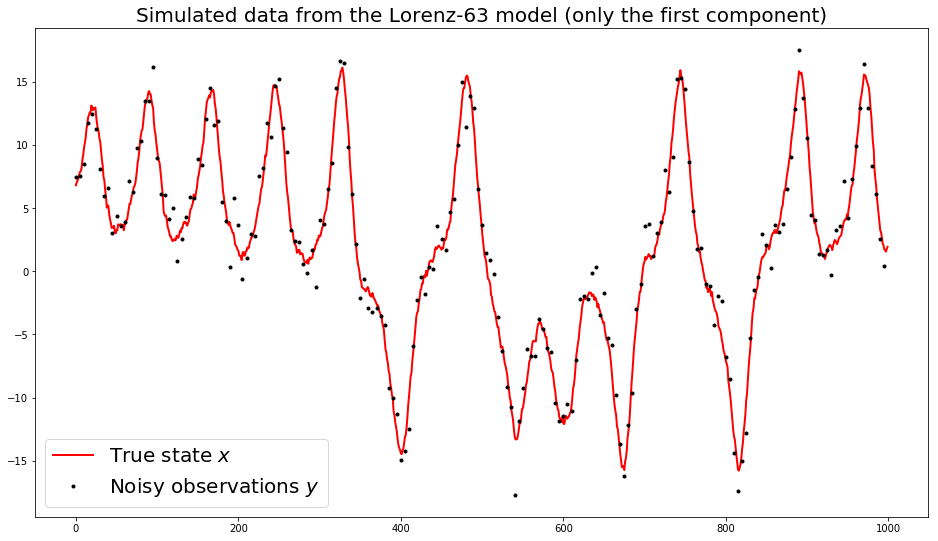

In [6]:
# import CEDA library
from numpy.random import RandomState
from models.L63 import l63_predict
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.utils import gen_truth, gen_obs, climat_background

# generate true state 
dt = .01 # integration time
sigma = 10;rho = 28;beta = 8./3 # physical parameters of Lorenz-63
m = lambda x: l63_predict(x, dt, sigma, rho, beta) # dynamic operator
h = lambda x: x # observation operator (nonlinear version)
H = eye(3) # observation operator (linear version)
K = 1000
Q_true = 0.05*eye(3)
x_true = gen_truth(m, r_[6.39435776, 9.23172442, 19.15323224], K, Q_true, RandomState(5))

# generate noisy observations
dt_obs = 5 # 1 observation every dt_obs time steps
R_true = 2*eye(3)
y = gen_obs(h, x_true, R_true, dt_obs, RandomState(5))

# plot results
figure()
line1,=plot(range(K),x_true[0,1:],'r',linewidth=2)
line2,=plot(range(K),y[0,:],'.k')
legend([line1, line2], ['True state $x$', 'Noisy observations $y$'], prop={'size': 20})
title('Simulated data from the Lorenz-63 model (only the first component)', fontsize=20)

Now, we apply the EnKS using the true parameters: $Q=Q^{true}$ and $R=R^{true}$. We plot the corresponding results. The estimated state using Kalman is close to the truth and the $95\%$ confidence interval seems realistic.

Text(0.5,1,'Results of the EnKS (only the first component)')

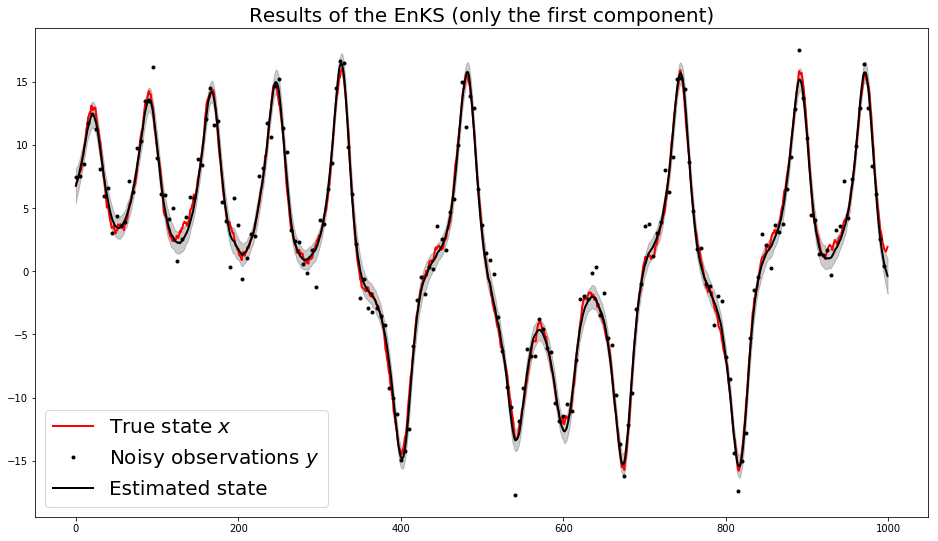

In [7]:
# apply EnKS with good covariances
params = { 'state_size'                  : 3,
           'nb_particles'                : 100,
           'temporal_window_size'        : K,
           'observation_matrix'          : H,
           'observation_noise_covariance': R_true,
           'observations'                : y,
           'true_state'                  : x_true,
           'observation_size'            : 3,
           'background_state'            : r_[6.39435776, 9.23172442, 19.15323224],
           'background_covariance'       : eye(3),
           'model_noise_covariance'      : Q_true,
           'inflation_factor'            : 1,
           'model_dynamics'              : m}
EnKS_true_Q_R=EnKS(params, RandomState(5))
ens_true_Q_R=EnKS_true_Q_R['smoothed_ensemble'] # smoother ensembles
xs_true_Q_R=mean(EnKS_true_Q_R['smoothed_ensemble'], 1)
Ps_true_Q_R=diag(cov(ens_true_Q_R[0,:,:], rowvar=False))

# plot results
figure()
line1,=plot(range(K),x_true[0,1:],'r',linewidth=2)
line2,=plot(range(K),y[0,:],'.k')
line3,=plot(range(K),xs_true_Q_R[0,1:],'k',linewidth=2)
fill_between(range(K), squeeze(xs_true_Q_R[0,1:]) - 1.96 * sqrt(squeeze(Ps_true_Q_R[1:])),
             squeeze(xs_true_Q_R[0,1:]) + 1.96 * sqrt(squeeze(Ps_true_Q_R[1:])), color='k', alpha=.2)
legend([line1, line2, line3], ['True state $x$', 'Noisy observations $y$', 'Estimated state'], prop={'size': 20})
title('Results of the EnKS (only the first component)', fontsize=20)

**Question)** Now, apply EnKS changing the values of $Q$ and $R$. First instance, increase significantly the observation or the model covariances and let's see whats happen. What are the impacts on the estimated mean ($x^s$) and covariance ($P^s$)?

Text(0.5,1,'Results with different EnKS configurations (only the first component)')

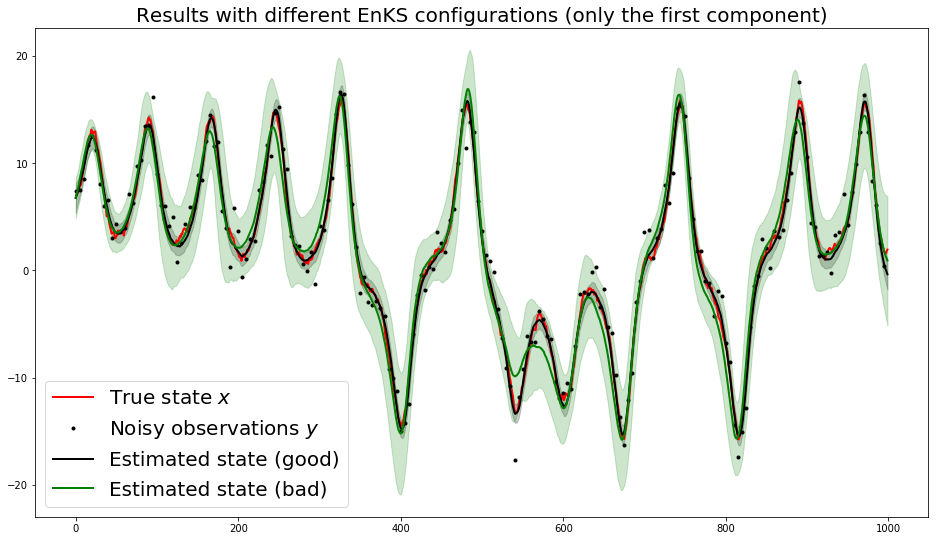

In [8]:
###########################
### HIDE THE WHOLE CELL ###
###########################

# apply Kalman smoother with bad covariances
params = { 'state_size'                  : 3,
           'nb_particles'                : 100,
           'temporal_window_size'        : K,
           'observation_matrix'          : H,
           'observation_noise_covariance': 100*R_true,
           'observations'                : y,
           'true_state'                  : x_true,
           'observation_size'            : 3,
           'background_state'            : r_[6.39435776, 9.23172442, 19.15323224],
           'background_covariance'       : eye(3),
           'model_noise_covariance'      : Q_true,
           'inflation_factor'            : 1,
           'model_dynamics'              : m}
EnKS_bad_Q_R=EnKS(params, RandomState(5))
ens_bad_Q_R=EnKS_bad_Q_R['smoothed_ensemble'] # smoother ensembles
xs_bad_Q_R=mean(EnKS_bad_Q_R['smoothed_ensemble'], 1)
Ps_bad_Q_R=diag(cov(ens_bad_Q_R[0,:,:], rowvar=False))

# plot results
figure()
line1,=plot(range(K),x_true[0,1:],'r',linewidth=2)
line2,=plot(range(K),y[0,:],'.k')
line3,=plot(range(K),xs_true_Q_R[0,1:],'k',linewidth=2)
fill_between(range(K), squeeze(xs_true_Q_R[0,1:]) - 1.96 * sqrt(squeeze(Ps_true_Q_R[1:])),
             squeeze(xs_true_Q_R[0,1:]) + 1.96 * sqrt(squeeze(Ps_true_Q_R[1:])), color='k', alpha=.2)
line4,=plot(range(K),xs_bad_Q_R[0,1:],'g',linewidth=2)
fill_between(range(K), squeeze(xs_bad_Q_R[0,1:]) - 1.96 * sqrt(squeeze(Ps_bad_Q_R[1:])),
             squeeze(xs_bad_Q_R[0,1:]) + 1.96 * sqrt(squeeze(Ps_bad_Q_R[1:])), color='g', alpha=.2)
legend([line1, line2, line3, line4], ['True state $x$', 'Noisy observations $y$', 'Estimated state (good)', 'Estimated state (bad)'], prop={'size': 20})
title('Results with different EnKS configurations (only the first component)', fontsize=20)

With bad specified covariances, the EnKS can diverge and this is the worst issue in data assimilation... To avoid this problem, we use the batch EM to estimate $Q$ and $R$ covariances. First, we initialize the state-space model with realistic $Q^{(0)}$ and $R^{(0)}$ values. Then, we run the EM algorithm with a given number of iterations.

[Puede ser que tarda mucho, pueden tomar un maté...]

In [9]:
N_iter = 100 # number of EM iterations
xb, B = climat_background(x_true) # background state

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : eye(3),
           'initial_observation_noise_covariance'     : eye(3),
           'model_dynamics'                           : m,
           'observation_matrix'                       : H,
           'observations'                             : y,
           'nb_particles'                             : 100,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : x_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : K,
           'state_size'                               : 3,
           'observation_size'                         : 3,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full'}

# function
res_EM_EnKS = EM_EnKS(params, RandomState(5))

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


We then plot the mean diagonal terms of $Q$ and $R$ along the iterations. We also plot the evolution of the likelihood and of the RMSE.

Text(0.5,1,'RMSE')

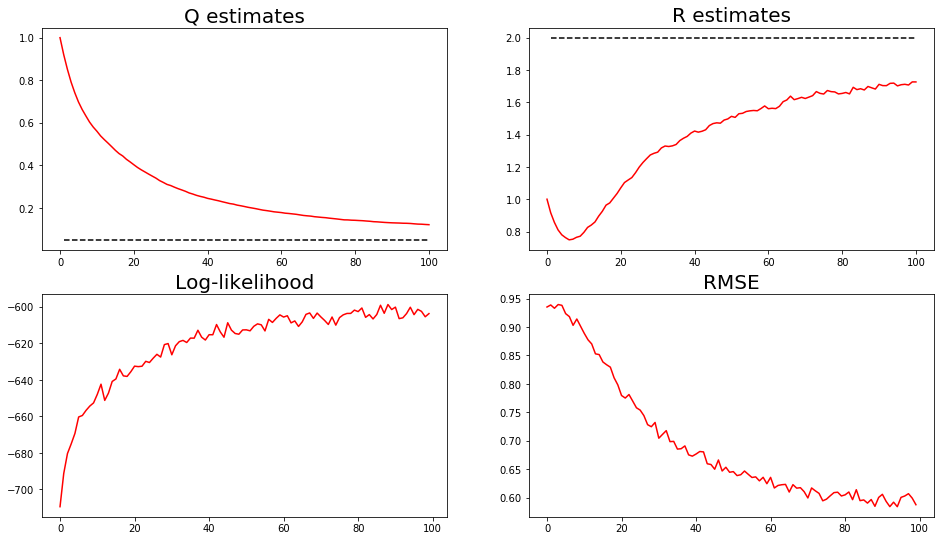

In [10]:
# extract outputs
Q_est=res_EM_EnKS['EM_model_noise_covariance']
R_est=res_EM_EnKS['EM_observation_noise_covariance']
loglik_est=res_EM_EnKS['loglikelihood']
RMSE_est=res_EM_EnKS['RMSE']

# plot trace of Q
subplot(2,2,1)
line1,=plot(trace(Q_est)/3,'r')
line2,=plot((1,N_iter),(trace(Q_true)/3,trace(Q_true)/3),'--k')
title('Q estimates', fontsize=20)

# plot trace of R
subplot(2,2,2)
line1,=plot(trace(R_est)/3,'r')
line2,=plot((1,N_iter),(trace(R_true)/3,trace(R_true)/3),'--k')
title('R estimates', fontsize=20)

# plot log-likelihood
subplot(2,2,3)
plot(loglik_est,'r')
title('Log-likelihood', fontsize=20)

# plot Root Mean Square Error
subplot(2,2,4)
plot(RMSE_est,'r')
title('RMSE', fontsize=20)

**Question)** Now, you are an expert! Play with the EM algorithm changing the values of the important parameters like *dt_obs* (the sampling of the observations) and *K* (the number of time steps).